In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import random
import io
import os
import unicodedata
import string
import glob


In [ ]:
#alphabet small + capital letter +".,"
ALL_LETTERS=string.ascii_letters+".,"
N_LETTERS=len(ALL_LETTERS)

In [ ]:
def unicode_to_ascii(s):
  return ''.join(
      c for c in unicodedata.normalize("NFD",s)
      if unicodedata.category(c)!='Mn'
      and c in ALL_LETTERS
  )

def load_data():
  #build the category_lines dictionary , a list of names per languages
  category_lines={}
  all_categories=[]


  def find_files(path):
    return glob.glob(path)

  def read_files(filename):
    lines=io.open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# /content/Arabic.txt
  for filename in find_files('/content/*.txt'):
    category=os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines=read_files(filename)
    category_lines[category]=lines
  return category_lines,all_categories


  """
  To represent a single letter, we use a "one-hot vector" of size <1 x n_letters>.
  A "one-hot vector" is filled with 0s except for a 1 at index of
  """

#Find letter index from all_letters, e.g. "a"=0
def letter_to_index(letter):
  return ALL_LETTERS.find(letter)

#Just for demonstration, turn a letter into a <1 x n_letters>Tensor
def letter_to_tensor(letter):
  tensor=torch.zeros(1,N_LETTERS)
  tensor[0][letter_to_index(letter)]=1
  return tensor

#Turn a line into a <line_length x 1 x n_letters>,
#or an array of one-hot letter vectors

def line_to_tensor(line):
  tensor=torch.zeros(len(line),1,N_LETTERS)
  for i,letter in enumerate(line):
    tensor[i][0][letter_to_index(letter)]=1
  return tensor

def random_training_example(category_lines,all_categories):
  def random_choice(a):
    random_idx=random.randint(0,len(a)-1)
    return a[random_idx]

  category=random_choice(all_categories)
  line=random_choice(category_lines[category])
  category_tensor=torch.tensor([all_categories.index(category)],dtype=torch.long)
  line_tensor=line_to_tensor(line)
  return category,line,category_tensor,line_tensor


18
Scottish
5000 5.0 nan Drassal / French WRONG (Czech)
10000 10.0 nan Brian / French WRONG (Irish)
15000 15.0 nan Hayden / French WRONG (Irish)
20000 20.0 nan Quang / French WRONG (Vietnamese)
25000 25.0 nan Sobol / French WRONG (Polish)
30000 30.0 nan Janowski / French WRONG (Polish)
35000 35.0 nan Serafim / French WRONG (Portuguese)
40000 40.0 nan Espinosa / French WRONG (Spanish)
45000 45.0 nan Lennon / French WRONG (Irish)
50000 50.0 nan Yan / French WRONG (Chinese)
55000 55.00000000000001 nan Tolbert / French CORRECT
60000 60.0 nan Chu / French WRONG (Vietnamese)
65000 65.0 nan Saidbaev / French WRONG (Russian)
70000 70.0 nan Chung / French WRONG (Korean)
75000 75.0 nan Shim / French WRONG (Korean)
80000 80.0 nan Jackson / French WRONG (Scottish)
85000 85.0 nan Tos / French WRONG (Spanish)
90000 90.0 nan Rocha / French WRONG (Portuguese)
95000 95.0 nan Raskop / French WRONG (German)
100000 100.0 nan Rompaij / French WRONG (Dutch)


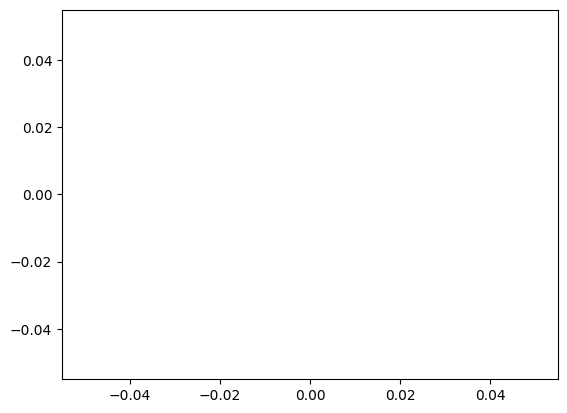

Input:Kunal

>Kunal
French
Input:Bob

>Bob
French
Input:Jack

>Jack
French
Input:Acker

>Acker
French
Input:Adler

>Adler
French


KeyboardInterrupt: Interrupted by user

In [ ]:
class RNN(nn.Module):
  #nn.RNN
  def __init__(self,input_size,hidden_size,output_size):
    super(RNN,self).__init__()

    self.hidden_size=hidden_size
    self.i2h=nn.Linear(input_size+hidden_size,hidden_size)
    self.i2o=nn.Linear(input_size+hidden_size,output_size)
    self.softmax=nn.LogSoftmax(dim=1)# 1 x 57

  def forward(self,input_tensor,hidden_tensor):
    combined=torch.cat((input_tensor,hidden_tensor),1)
    hidden=self.i2h(combined)
    output=self.i2o(combined)
    output=self.softmax(output)
    return output,hidden


  def init_hidden(self):
    return torch.zeros(1,self.hidden_size)

category_lines,all_categories=load_data()
n_categories=len(all_categories)
print(n_categories)
n_hidden=128
rnn=RNN(N_LETTERS,n_hidden,n_categories)

# #one step
input_tensor=letter_to_tensor('A')
hidden_tensor=rnn.init_hidden()

output,next_hidden=rnn(input_tensor,hidden_tensor)
# print(output.size())
# print(next_hidden.size())


# #whole sequence/name
input_tensor=line_to_tensor('Albert')
hidden_tensor=rnn.init_hidden()

output,next_hidden=rnn(input_tensor[0],hidden_tensor)
# print(output.size())
# print(next_hidden.size())


def category_from_output(output):
  category_idx=torch.argmax(output).item()
  return all_categories[category_idx]

print(category_from_output(output))

criterion = nn.NLLLoss()
learning_rate=0.895
optimizer=torch.optim.SGD(rnn.parameters(),lr=learning_rate)

def train(line_tensor,category_tensor):
  hidden=rnn.init_hidden()
  optimizer.zero_grad()

  for i in range(line_tensor.size()[0]):
    output,hidden=rnn(line_tensor[i],hidden)


  loss=criterion(output,category_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output,loss.item()

current_loss=0
all_losses=[]
plot_step,print_step=1000,5000
n_iters=100000
for i in range(n_iters):
  category,line,category_tensor,line_tensor=random_training_example(category_lines,all_categories)
  output,loss=train(line_tensor,category_tensor)
  current_loss+=loss

  if (i+1)%plot_step==0:
    all_losses.append(current_loss/plot_step)
    current_loss=0

  if (i+1) % print_step == 0:
      guess = category_from_output(output)
      correct = "CORRECT" if guess == category else f"WRONG ({category})"
      print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

plt.figure()
plt.plot(all_losses)
plt.show()

def predict(input_line):
  print(f"\n>{input_line}")
  with torch.no_grad():
    line_tensor=line_to_tensor(input_line)
    hidden=rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
      output,hidden=rnn(line_tensor[i],hidden)

    guess=category_from_output(output)
    print(guess)






while True:
  sentence=input("Input:")
  if sentence=="quit":
    break

  predict(sentence)



Chinese
5000 5.0 2.4509 Rosario / Italian WRONG (Portuguese)
10000 10.0 0.4252 Antonopoulos / Greek CORRECT
15000 15.0 3.2213 Philips / Japanese WRONG (Dutch)
20000 20.0 1.4787 Stramba / Czech CORRECT
25000 25.0 3.2263 Reynold / English WRONG (Irish)
30000 30.0 1.1221 Jong / Chinese WRONG (Korean)
35000 35.0 0.3949 Vuong / Vietnamese CORRECT
40000 40.0 0.5534 Dubhan / Irish CORRECT
45000 45.0 1.2195 Kaza / Japanese CORRECT
50000 50.0 1.9195 Kaluza / Czech WRONG (Polish)
55000 55.00000000000001 0.9254 Damhain / Irish CORRECT
60000 60.0 0.9306 Zhuo / Chinese CORRECT
65000 65.0 1.3398 Bitar / Arabic CORRECT
70000 70.0 1.2014 Rong / Korean WRONG (Chinese)
75000 75.0 2.0145 Fallon / Scottish WRONG (English)
80000 80.0 0.6183 Pereira / Portuguese CORRECT
85000 85.0 2.4800 Pinter / German WRONG (Czech)
90000 90.0 0.5828 Sobol / Polish CORRECT
95000 95.0 0.8448 Yin / Korean WRONG (Chinese)
100000 100.0 1.1030 Damhan / Irish CORRECT


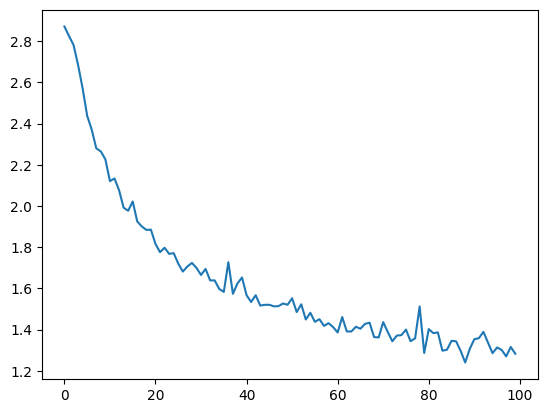

Input:joe

> joe
Korean


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt



class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
#print(output.size())
#print(next_hidden.size())

# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
#print(output.size())
#print(next_hidden.size())

#
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")


plt.figure()
plt.plot(all_losses)
plt.show()

def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)


while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)
